# Predição de séries temporais de carga elétrica
Este notebook coleta, organiza e visualiza dados públicos da ENTSO‑E para construir conjuntos de treino e avaliação de modelos de previsão temporal.
Autor: Victor Mario Bertini (RA: 194761)

# Capítulo 1 — Coleta de dados
Nesta etapa baixamos dados da ENTSO‑E via API REST e salvamos em formato Parquet dentro da pasta `data/`. O objetivo é permitir reexecuções parciais: cada subetapa persiste artefatos para evitar refazer todo o fluxo.
Fonte: https://transparency.entsoe.eu/content/static_content/Static%20content/web%20api/Guide.html
Escopo desta versão do notebook:
- Países europeus selecionados (FR, ES, PT - França,  Espanha, Portugal)
- Datasets principais:
  - Load — Actual Total (carga realizada agregada)
  - Market — Energy Prices (preços de energia)
- Período: até 180 dias retroativos
Subcapítulos desta etapa:
1. Coleta e salvamento bruto (Parquet)
2. Visualização exploratória (carga e preço)
3. Preparação de dados para treino

## Dependências

In [10]:
# Checagem/instalação leve de dependências
print("Verificando dependências (pyarrow para Parquet)...")

try:
    import pyarrow as pa
    print(f"PyArrow disponível: {pa.__version__}")
except Exception:
    print("Instalando pyarrow...")
    !pip install --upgrade "pyarrow>=18" --quiet
    import importlib
    importlib.invalidate_caches()
    import pyarrow as pa
    print(f"PyArrow instalado: {pa.__version__}")

# fastparquet é opcional
try:
    import fastparquet  # noqa: F401
    print("fastparquet disponível (opcional)")
except Exception:
    pass

# Outras bibliotecas sob demanda
for lib in [
    "numpy", "python-dotenv", "pandas", "matplotlib", "seaborn",
    "scikit-learn", "tensorflow", "keras", "lxml", "pytz", "requests", "optuna"
]:
    try:
        __import__(lib)
    except ImportError:
        print(f"Instalando {lib}...")
        !pip install {lib} --quiet

print("Dependências prontas")

Verificando dependências (pyarrow para Parquet)...
PyArrow disponível: 22.0.0
Instalando python-dotenv...
Instalando scikit-learn...
Dependências prontas


## Coleta de dados brutos

In [11]:
# Imports para a API e utilidades
import os
import requests
import pandas
from dotenv import load_dotenv
from datetime import datetime, timedelta, date
import pytz
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Carregar variáveis de ambiente do .env
load_dotenv()

True

### Definição de funções de coleta de dados e de salvamento em parquet

In [12]:
import os
import re
import time
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed

import pandas as pd
import requests
from lxml import etree

# ---------------- CONFIG ---------------- #
COUNTRY_DOMAINS = {
    "FR": {"domain": "10YFR-RTE------C"},
    "ES": {"domain": "10YES-REE------0"},
    "PT": {"domain": "10YPT-REN------W"}
}

DATA_ITEMS = [
    {'key': 'load_total', 'documentType': 'A65', 'processType': 'A16', 'domainParam': 'outBiddingZone_Domain', 'parser': 'load'},
    {'key': 'market_prices', 'documentType': 'A44', 'processType': 'A07', 'domainParamIn': 'in_Domain', 'domainParamOut': 'out_Domain', 'parser': 'price'}
]

ENTSOE_TOKEN = os.environ.get("ENTSOE_SECURITY_TOKEN")
BASE_URL = "https://web-api.tp.entsoe.eu/api"
MAX_WORKERS = 100
RAW_DIR = os.path.join("data", "raw")
PARQUET_COMPRESSION = "zstd"
os.makedirs(RAW_DIR, exist_ok=True)

# ---------------- HELPERS ---------------- #
def build_params(item, domain, start_dt, end_dt):
    """Build API query parameters."""
    return {
        "securityToken": ENTSOE_TOKEN,
        "documentType": item['documentType'],
        "periodStart": start_dt.strftime("%Y%m%d%H%M"),
        "periodEnd": end_dt.strftime("%Y%m%d%H%M"),
        **({"processType": item['processType']} if item.get('processType') else {}),
        **({item['domainParamIn']: domain, item['domainParamOut']: domain} if item.get('domainParamIn') else {item.get('domainParam'): domain})
    }

def parse_xml_points(xml_bytes: bytes, parser_type: str) -> pd.DataFrame:
    """Parse ENTSO-E XML response into a DataFrame with proper datetime."""
    root = etree.fromstring(xml_bytes)
    period_elem = root.find(".//{*}Period")
    if period_elem is None:
        return pd.DataFrame()

    start_elem = period_elem.find("{*}timeInterval/{*}start")
    period_start = start_elem.text if start_elem is not None else None

    res_elem = period_elem.find("{*}resolution")
    resolution = res_elem.text if res_elem is not None else None

    rows = []
    for point in period_elem.findall("{*}Point"):
        pos_elem = point.find("{*}position")
        if pos_elem is None or pos_elem.text is None:
            continue
        pos = int(pos_elem.text)

        if parser_type == "load":
            val_elem = point.find("{*}quantity")
            if val_elem is None or val_elem.text is None:
                continue
            rows.append({
                'position': pos,
                'quantity_MW': float(val_elem.text),
                'period_start': period_start,
                'resolution': resolution
            })
        elif parser_type == "price":
            val_elem = point.find("{*}price.amount")
            if val_elem is None or val_elem.text is None:
                continue
            rows.append({
                'position': pos,
                'price_EUR_MWh': float(val_elem.text),
                'period_start': period_start,
                'resolution': resolution
            })

    df = pd.DataFrame(rows)
    
    if not df.empty and 'period_start' in df.columns and 'resolution' in df.columns:
        # extract minutes from resolution string (positions 2:4)
        df['minutes'] = df['resolution'].str[2:4].astype(int)
        df['datetime'] = pd.to_datetime(df['period_start'], utc=True) + pd.to_timedelta((df['position'] - 1) * df['minutes'], unit='minutes')
        df.drop(columns=['minutes'], inplace=True)
    
    return df

def fetch_day(session, item, country, day: datetime, retries=3, delay=5):
    """Fetch a single day of data for a given country and item."""
    domain = COUNTRY_DOMAINS[country]['domain']
    start_dt = day
    end_dt = start_dt + timedelta(days=1)
    params = build_params(item, domain, start_dt, end_dt)

    for attempt in range(retries):
        try:
            r = session.get(BASE_URL, params=params, timeout=30)
            r.raise_for_status()
            df = parse_xml_points(r.content, item['parser'])
            if df.empty:
                return pd.DataFrame()
            df['country'] = country
            return df
        except (requests.exceptions.RequestException, etree.XMLSyntaxError) as e:
            print(f"[WARNING] Attempt {attempt+1} failed for {country} {item['key']} {day}: {e}")
            time.sleep(delay * (2 ** attempt))
    return pd.DataFrame()

def daterange(start: datetime, end: datetime):
    """Yield datetime objects for each day between start and end, inclusive of start, exclusive of end."""
    current = start
    while current < end:
        yield current
        current += timedelta(days=1)

def fetch_last_days(lookback_days: int, reference_datetime: datetime = None) -> pd.DataFrame:
    """
    Fetch ENTSO-E data for the last `lookback_days` days, rounding reference time down to the previous full hour.
    """
    if reference_datetime is None:
        reference_datetime = datetime.now()

    # Round down to previous hour
    end_dt = reference_datetime.replace(minute=0, second=0, microsecond=0)
    start_dt = end_dt - timedelta(days=lookback_days)

    print(f"[INFO] Fetching data from {start_dt} to {end_dt} (rounded to hour)")

    all_dfs = []
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = []
        with requests.Session() as session:
            for item in DATA_ITEMS:
                for country in COUNTRY_DOMAINS:
                    for single_day in daterange(start_dt, end_dt):
                        futures.append(executor.submit(fetch_day, session, item, country, single_day))
            for f in as_completed(futures):
                df = f.result()
                if not df.empty:
                    all_dfs.append(df)

    if all_dfs:
        merged = pd.concat(all_dfs, ignore_index=True)
        merged = merged.pivot_table(index=['datetime', 'country'],
                                    values=['quantity_MW', 'price_EUR_MWh'],
                                    aggfunc='first').reset_index()
        merged['quantity_MW'] = merged.groupby('country')['quantity_MW'].ffill()
        merged['price_EUR_MWh'] = merged.groupby('country')['price_EUR_MWh'].ffill()

        # ==========================================
        # 🔽 Downsample to hourly datetimes (H over H)
        # ==========================================
        merged['datetime'] = pd.to_datetime(merged['datetime'], utc=True)

        # groupby–resample safely without duplicate 'country'
        merged = (
            merged
            .set_index('datetime')
            .groupby('country', group_keys=False)
            .resample('1H')
            .first()   # or .mean() if you want hourly averages
            .reset_index()
        )

        # ==========================================
        # Save hourly-parquet dataset
        # ==========================================
        filename = "raw_dataset.parquet"
        path = os.path.join(RAW_DIR, filename)
        merged.to_parquet(path, engine="pyarrow",
                          compression=PARQUET_COMPRESSION, index=False)
        print(f"[INFO] Saved merged hourly data to {path}")
        return merged

    else:
        return pd.DataFrame(columns=['datetime', 'country', 'quantity_MW', 'price_EUR_MWh'])



## Coletando dados
Nesta seção vamos buscar dados históricos de carga (A65) e preços de energia (A44). O período é exclusivamente passado (até ontem):
- Carga (A65): outBiddingZone_Domain = <EIC do país>
- Preços de energia (A44): in_Domain = <EIC do país> e out_Domain = <EIC do país>
Os resultados serão salvos como arquivos Parquet em `data/` para reutilização nas próximas etapas.

In [13]:
lookback_days = 200
df = fetch_last_days(lookback_days)

[INFO] Fetching data from 2025-04-16 23:00:00 to 2025-11-02 23:00:00 (rounded to hour)


[WARNING] Attempt 1 failed for PT load_total 2025-10-20 23:00:00: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
[WARNING] Attempt 1 failed for PT load_total 2025-10-27 23:00:00: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
[WARNING] Attempt 1 failed for FR market_prices 2025-05-31 23:00:00: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
[WARNING] Attempt 1 failed for FR market_prices 2025-06-13 23:00:00: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
[WARNING] Attempt 1 failed for FR market_prices 2025-05-27 23:00:00: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
[WARNING] Attempt 1 failed for FR market_prices 2025-05-26 23:00:00: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
[WARNING] Attempt 1 failed for FR 

/tmp/ipykernel_172218/2240045241.py:165: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('1H')
/tmp/ipykernel_172218/2240045241.py:166: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .first()   # or .mean() if you want hourly averages


## Visualização dos dados

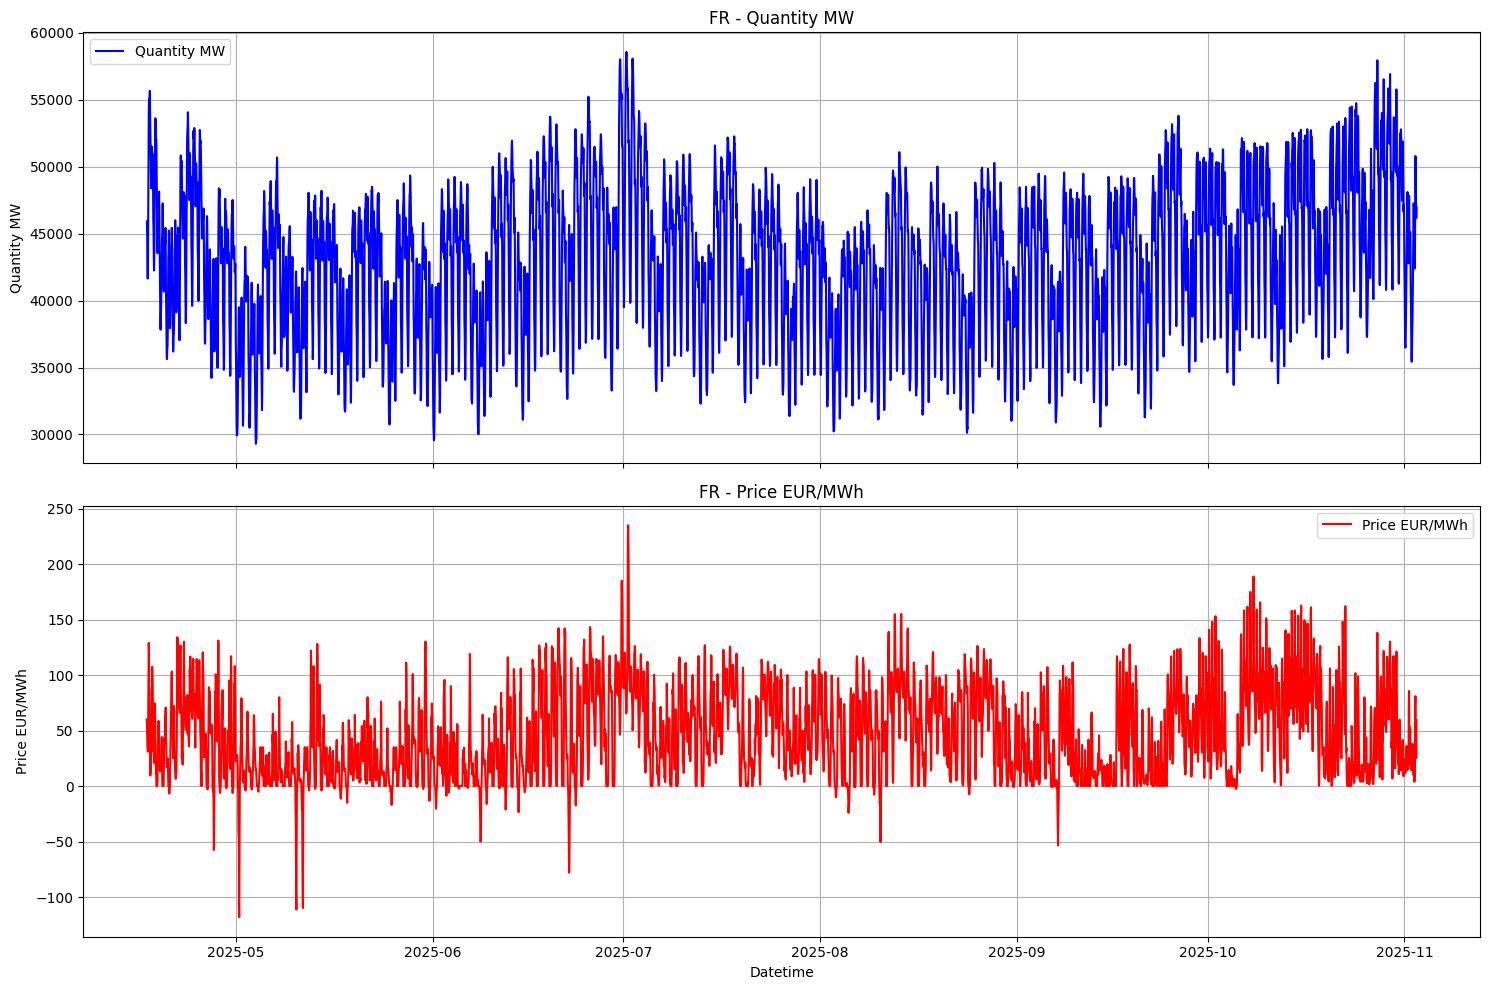

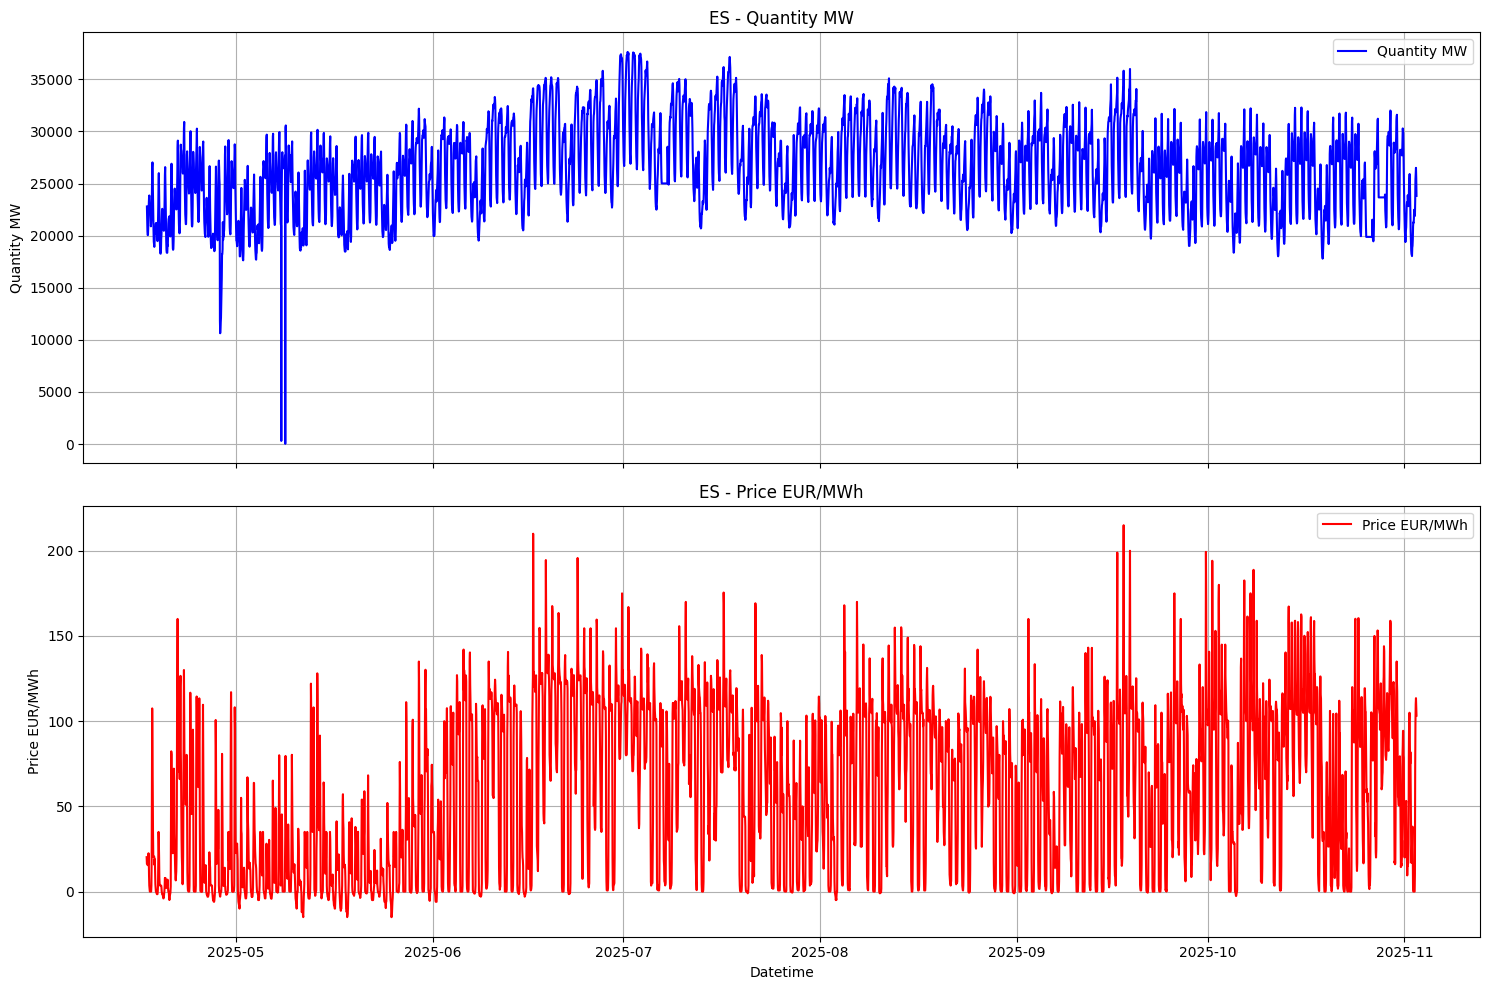

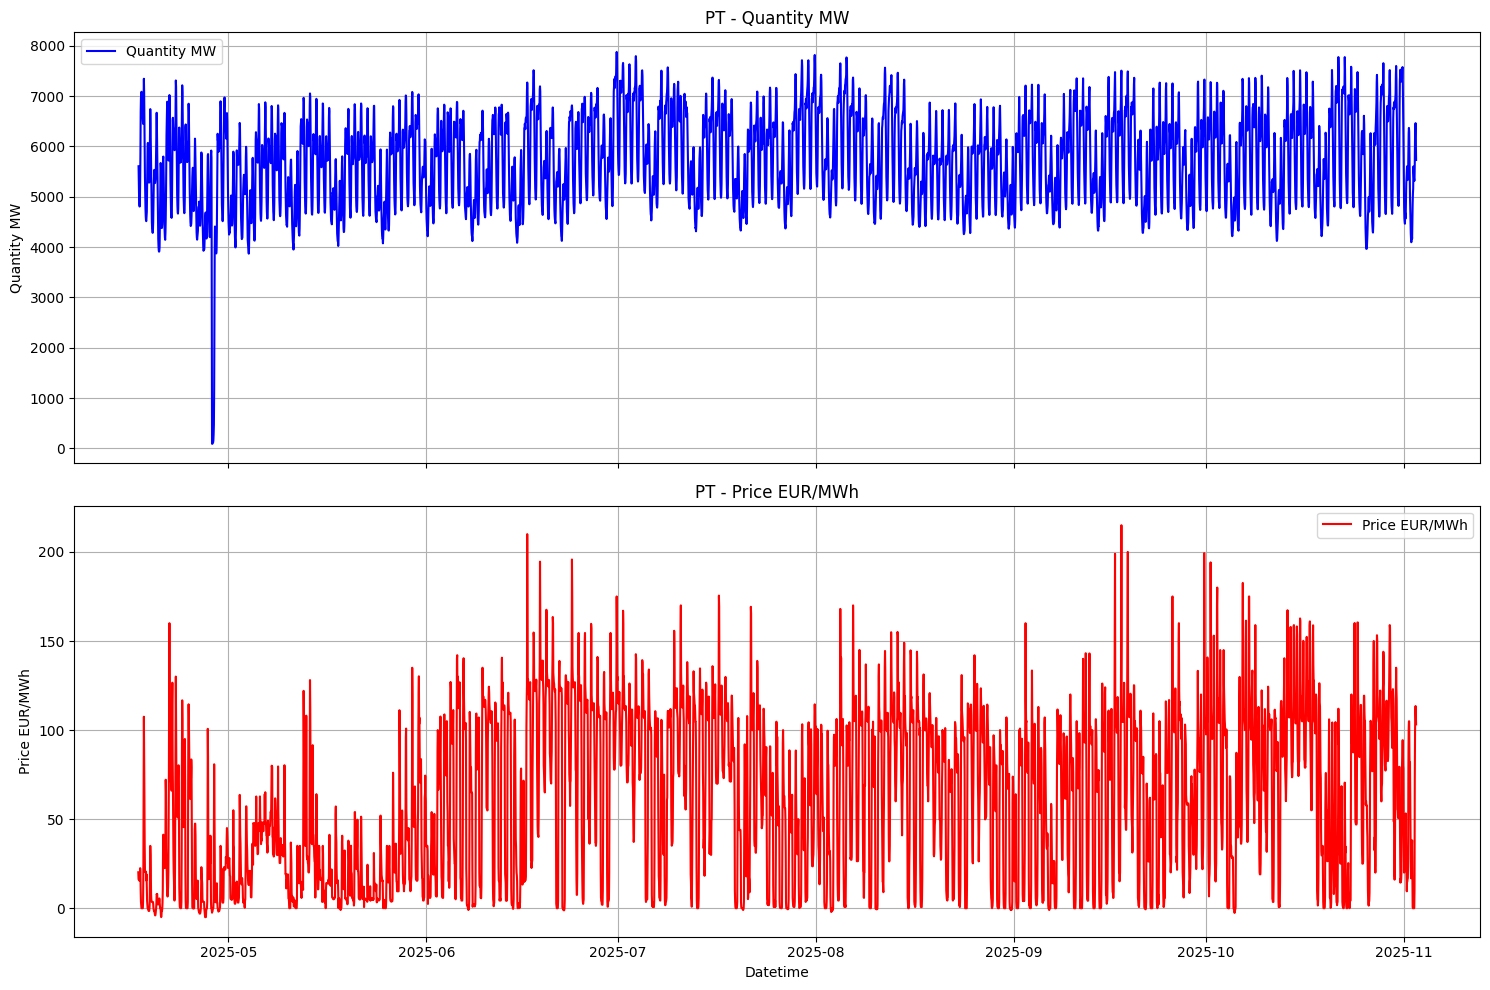

In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- CONFIG ---------------- #
RAW_DIR = "data/raw"
PARQUET_FILE = os.path.join(RAW_DIR, "raw_dataset.parquet")

for country in COUNTRY_DOMAINS.keys():
    # ---------------- LOAD DATA ---------------- #
    if not os.path.exists(PARQUET_FILE):
        raise FileNotFoundError(f"Parquet file not found at {PARQUET_FILE}. Run fetch_last_days() first.")

    df = pd.read_parquet(PARQUET_FILE)

    # Filter by country and sort by datetime
    df = df[df['country'] == country].sort_values('datetime')

    # ---------------- PLOTTING ---------------- #
    fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

    # Plot Quantity MW
    axes[0].plot(df['datetime'], df['quantity_MW'], color='blue', label='Quantity MW')
    axes[0].set_ylabel('Quantity MW')
    axes[0].set_title(f'{country} - Quantity MW')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Price EUR/MWh
    axes[1].plot(df['datetime'], df['price_EUR_MWh'], color='red', label='Price EUR/MWh')
    axes[1].set_ylabel('Price EUR/MWh')
    axes[1].set_title(f'{country} - Price EUR/MWh')
    axes[1].legend()
    axes[1].grid(True)

    # Common X-axis
    plt.xlabel('Datetime')
    plt.tight_layout()
    plt.show()


## Capitulo 2 — Definição dos Problemas (Carga e Mercado)

Nesta etapa definimos três problemas, agora baseados em carga (load) e mercado (preço de energia). Cada problema possui variantes A/B/C para complexidade crescente.

- Nível 1 — Previsão de carga - feature de carga (A65)
  - A: 1 país (ex.: AT), lookback curto (7 dias), horizonte 1 dia (96 passos de 15 min)
  - B: 1 país, lookback longo (15 dias), horizonte 3 dias
  - C: Multi-país (ex.: AT/DE/FR) com lookbacks máximo (30 dias) horizonte de 7 dias 

- Nível 2 — Previsão de carga e preço de mercado- feature de carga + preço de mercado (A44 + A65)
  - A/B/C como acima, mas prevendo simultaneamente preço e carga

Abaixo, criamos construtores de datasets (builders) que leem os Parquets salvos em `data/` e montam janelas de treino com passo de 15 minutos, iniciando sempre à meia‑noite do dia. Os builders retornam tuplas (X, Y, feat_cols, target_cols, country).
